In [142]:
import amigo
from amigo.optical_models import AMIOptics
import os
import sys
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
import dLux.utils as dlu
import dLux as dl

# Basic jax import
jax.config.update("jax_enable_x64", True)


from jax.scipy.special import gammaln, xlogy

def poisson_loglike_gamma(k, mu):
    # analytic continuation using gammaln(k+1)
    k = np.asarray(k)
    mu = np.asarray(mu)
    valid = (k >= 0) & np.isfinite(k) & (mu > 0) & np.isfinite(mu)
    logp = xlogy(k, mu) - mu - gammaln(k + 1.0)
    return np.where(valid, logp, -np.inf)

def poisson_loglike_unnormalized(k, mu):
    # returns k*log(mu) - mu  (no normalization constant)
    return xlogy(k, mu) - mu

# define the likelihood function:
def poiss_loglike(pytree, data) -> float:
    """
    Poissonian log likelihood of the pytree given the data. Assumes the pytree
    has a .model() function.

    Parameters
    ----------
    pytree : Base
        Pytree with a .model() function.
    data : Array
        Data to compare the model to.

    Returns
    -------
    log_likelihood : Array
        Log likelihood of the pytree given the data.
    """
    return poisson_loglike_gamma(pytree.model(), data).sum()

plt.rcParams["image.origin"] = 'lower'

# import alpha cen
from dLuxToliman import AlphaCen, TolimanOpticalSystem
import zodiax as zdx

In [143]:
ami_optics = AMIOptics(psf_npixels=40)
# 40 npixels because we're simulating the bottom right array which is the best according to Ben
print(ami_optics)

AMIOptics(
  wf_npixels=1024,
  diameter=6.603464,
  layers={
    'InvertY': Flip(axes=0),
    'pupil_mask':
    StaticApertureMask(
      transmission=f64[1024,1024],
      normalise=True,
      abb_basis=f64[7,10,180,180],
      abb_coeffs=f64[7,10],
      amp_basis=f64[7,10,180,180],
      amp_coeffs=f64[7,10],
      corners=i64[7,2]
    )
  },
  psf_npixels=40,
  oversample=3,
  psf_pixel_scale=0.065524085,
  filters={'F380M': f64[2,9], 'F430M': f64[2,9], 'F480M': f64[2,9]},
  defocus_type='fft',
  defocus=f64[],
  corners=i64[7,2],
  psf_upsample=3
)


In [144]:
# I wonder if I can make it a dLux telescope?
# from F480M filter
wlweights = np.array([[4.58283333e-06, 4.64250000e-06, 4.70216667e-06, 4.76183333e-06,
        4.82150000e-06, 4.88116667e-06, 4.94083333e-06, 5.00050000e-06,
        5.06016667e-06],
       [4.83897537e-03, 4.27569626e-02, 1.79674591e-01, 1.84285712e-01,
        2.00072602e-01, 1.85606063e-01, 1.65577628e-01, 3.61394316e-02,
        1.04803396e-03]])

# just a bunch of wavelengths
wavelengths = wlweights[0]
weights = wlweights[1]

# let us instead make a polynomial spectrum
# of the form wavelengths, coefficients
# this will double the spectral weight over the bandpass
spectrum = dl.PolySpectrum(wavelengths, np.array([-8.54,2083333]))

In [ ]:
log_fluxes = np.linspace(7,10,4)

flux = 10**(log_fluxes[0]) #6.016
# binary source,
# going to have to import alpha cen because it has individial x and y position ? no
# source = AlphaCen(wavelengths=wavelengths, log_flux=np.log10(flux))
separation = 2*4.80e-6/6.603464 # lambda/d separation

# 100:1 contrast ratio?
contrast = 100
source = dl.BinarySource(spectrum=spectrum, position=dlu.arcsec2rad(np.array([0,0])), 
                        mean_flux=flux, separation=separation, position_angle=np.pi/2, contrast=contrast)

## could just make a new point source
# source = dl.PointSource(wavelengths=wavelengths, position = dlu.arcsec2rad(np.array([0,0])), flux = flux)

# optional detector
detector_layers = [
    (
        'downsample',
        dl.detector_layers.Downsample(3)
    )
]
detector = dl.LayeredDetector(detector_layers)

# try extracting the AMI optics and putting it into a normal dlux system.. this is SO JANK
transmission = ami_optics.transmission
aperture_layer = dl.TransmissiveLayer(transmission, True)

layers = [
    (
        'aperture',
        aperture_layer
    )
]
optics = dl.AngularOpticalSystem(wf_npixels=1024, diameter=6.603464, psf_npixels=80, oversample=3, psf_pixel_scale=0.065524085, layers=layers)

# setting up the dithers

In [ ]:
THRESH = 30_000.0
angle = np.pi/4

def peak_at_radius(radial_arcsec, angle, optics, source, detector):
    # Build dithers for this radius (angle=0; tweak as needed)
    x = radial_arcsec * np.cos(angle)
    y = radial_arcsec * np.sin(angle)
    dithers = dlu.arcsec2rad(np.array([[x, -y]]))  # shape (1,2)
    model = dl.Dither(dithers, optics, source, detector)
    data = model.model()
    return np.max(data)

def bracket_threshold(angle, optics, source, detector, r_init=0.0, step=0.25, r_max=20.0):
    r = r_init
    p = float(peak_at_radius(r, angle, optics, source, detector))
    if p <= THRESH:
        return r_init, r_init  # already saturated at start
    while r < r_max:
        r_next = r + step
        p_next = float(peak_at_radius(r_next, angle, optics, source, detector))
        if p_next <= THRESH:
            return r, r_next  # bracket found
        r, step = r_next, step*1.5  # expand step geometrically
    return None, None  # never reaches threshold

def bisection_min_radius(angle, optics, source, detector, r_lo, r_hi, iters=30):
    # assumes peak(r_lo) < THRESH <= peak(r_hi)
    for _ in range(iters):
        r_mid = 0.5*(r_lo + r_hi)
        p_mid = float(peak_at_radius(r_mid, angle, optics, source, detector))
        if p_mid <= THRESH:
            r_hi = r_mid
        else:
            r_lo = r_mid
    return r_hi

r_lo, r_hi = bracket_threshold(angle, optics, source, detector, r_init=0.0, step=0.1, r_max=20.0)
if r_lo is None:
    print("Never hits 30k within 10 arcsec.")
else:
    r_star = bisection_min_radius(angle, optics, source, detector, r_lo, r_hi, iters=28)
    print("Smallest radius hitting leq 30k:", r_star, "arcsec")

# wow epic

Smallest radius hitting leq 30k: 4.217328743907274 arcsec


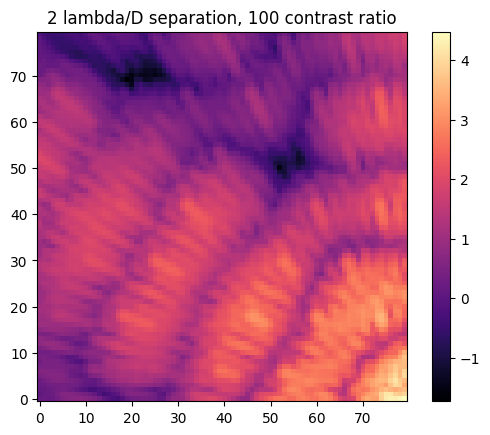

maximum photoelectron count:
29999.997909209837


In [259]:
# alright this is looking good!
radial_dist = r_star #arcsec

x_dither = radial_dist * np.cos(angle)
y_dither = radial_dist * np.sin(angle)
dithers = dlu.arcsec2rad(np.array([[x_dither,-y_dither]]))
model = dl.Dither(dithers, optics, source, detector)

data = model.model()

plt.imshow(np.log10(data[0]), origin='lower', cmap='magma')
plt.colorbar()
plt.title('2 lambda/D separation, 100 contrast ratio')
plt.show()
print('maximum photoelectron count:')
print(np.max(data))

In [260]:
# parameters
marginal_params = ['separation', 'position_angle', 'mean_flux', 'contrast', 'wavelengths', 'coefficients', 'position']
# marginalise over mean wavelength ..??? ?? 
shape_dict = {'wavelengths': (1,)}

cov = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data, shape_dict=shape_dict)

/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


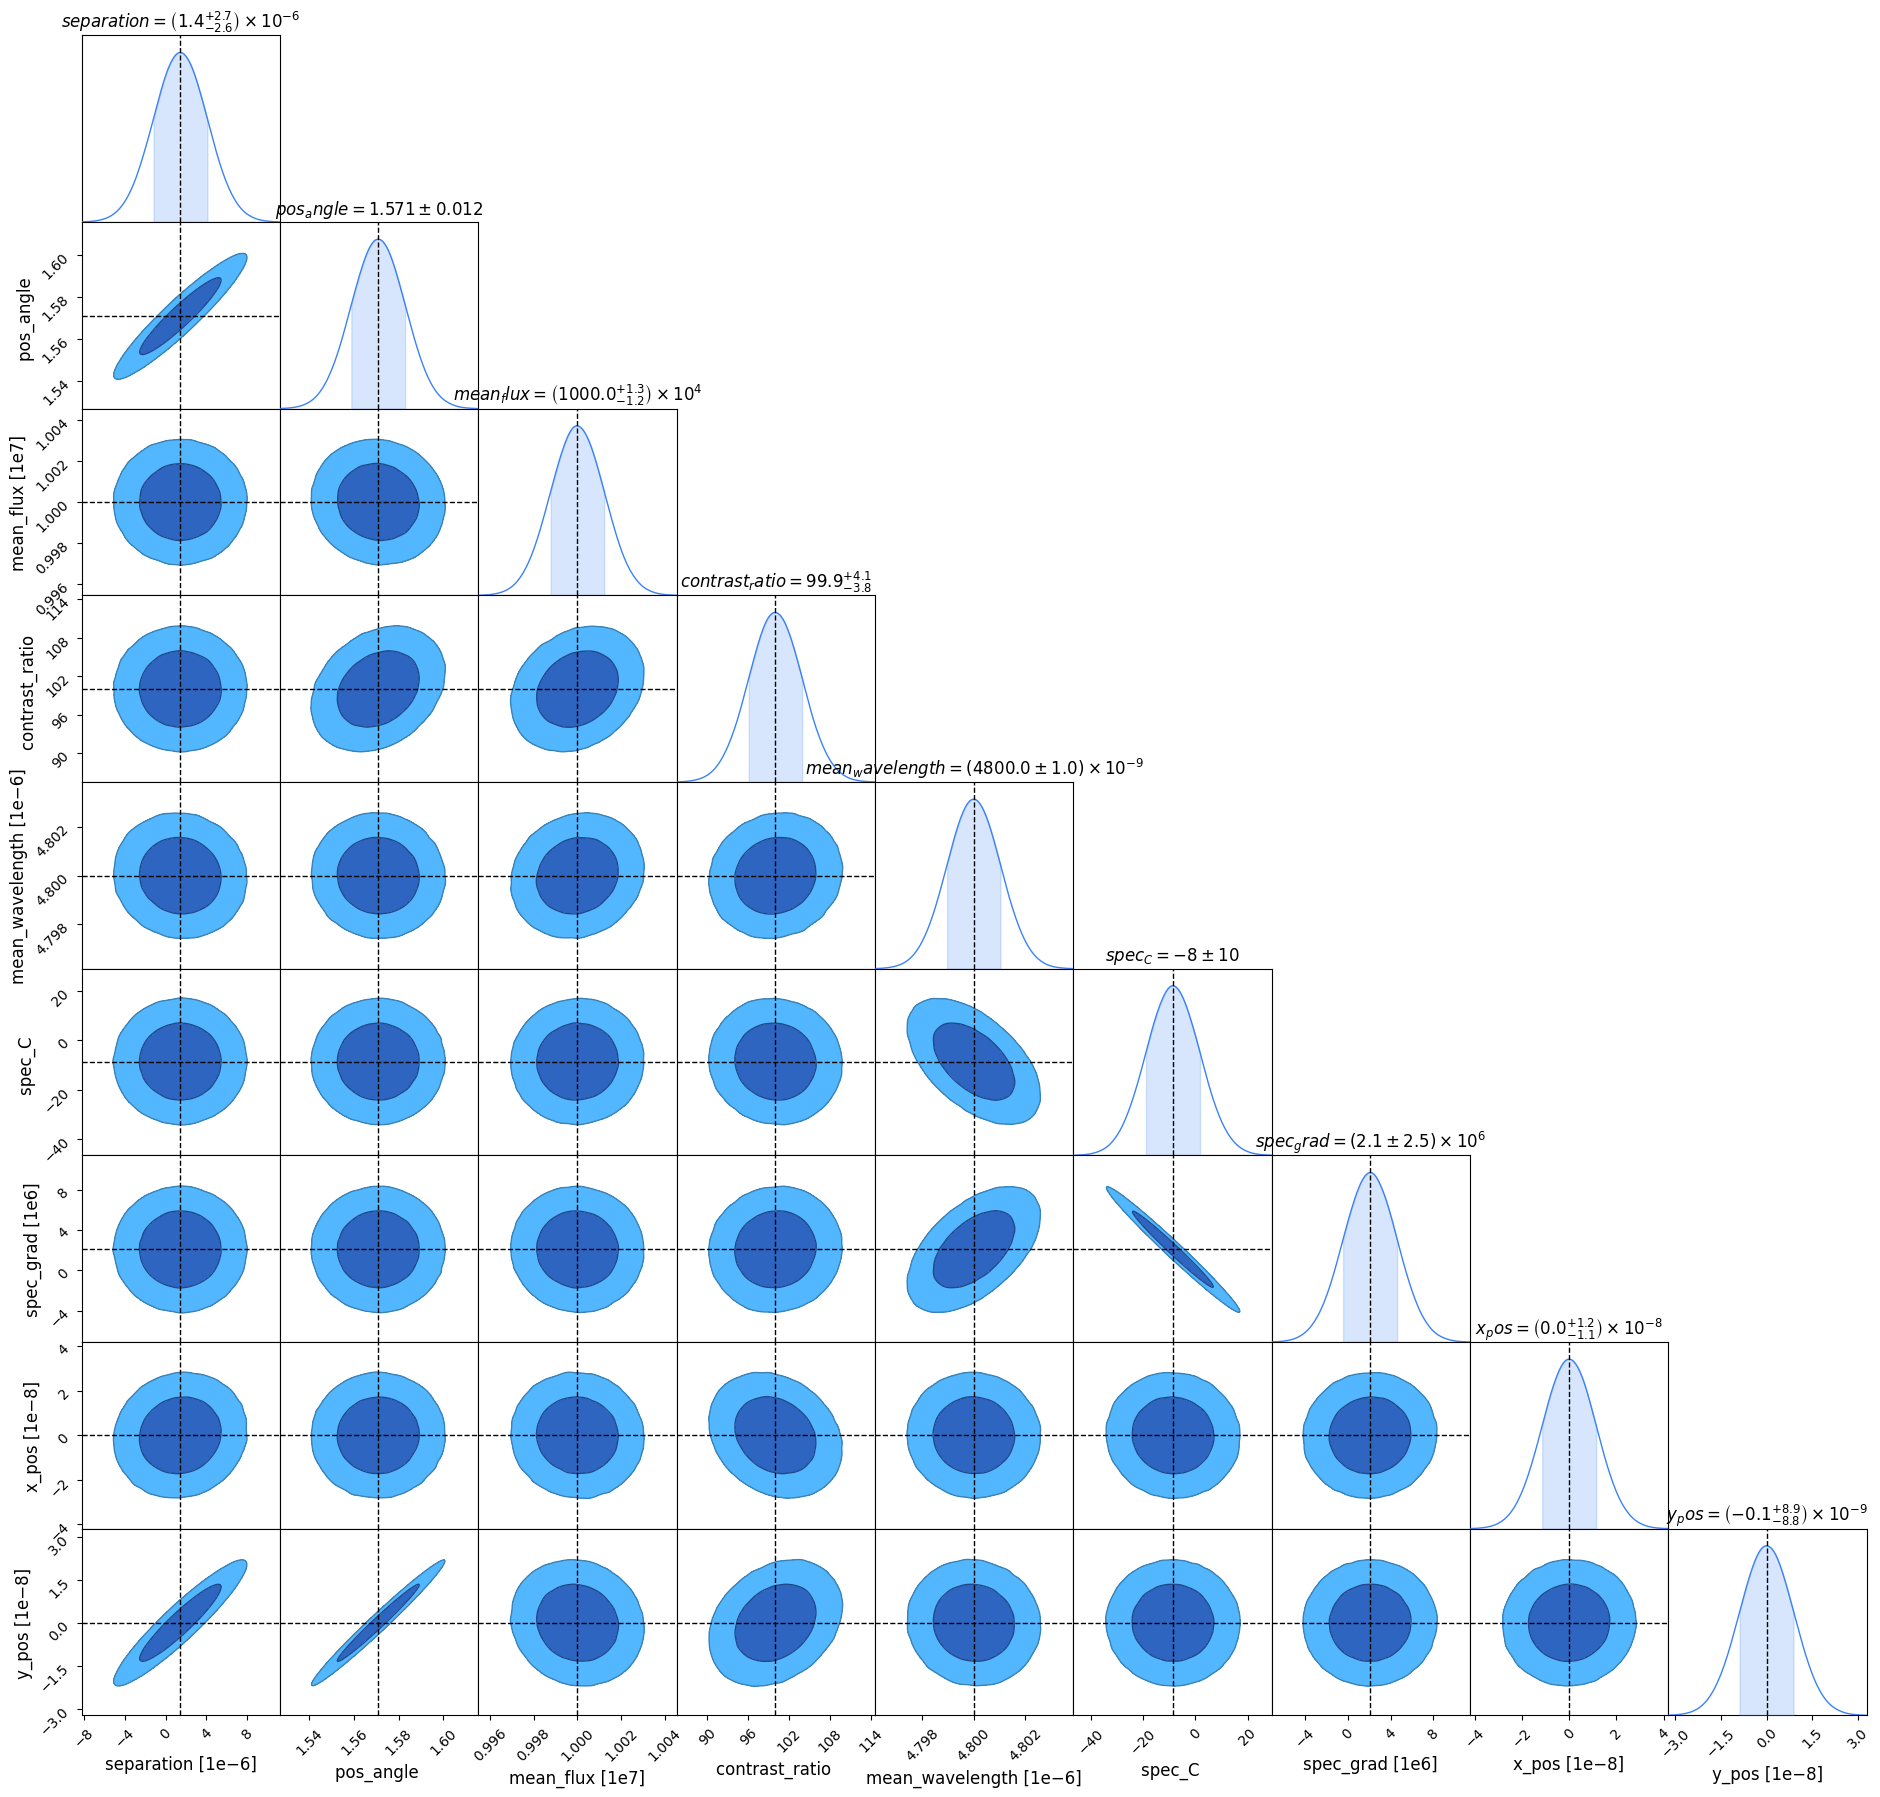

In [261]:
from chainconsumer import ChainConsumer, Chain, Truth
param_names = ['separation', 'pos_angle', 'mean_flux', 'contrast_ratio', 'mean_wavelength', 'spec_C', 'spec_grad', 'x_pos', 'y_pos']
X = np.zeros(len(param_names))
X = np.array([separation, np.pi/2, flux, contrast, 4.8e-6, -8.54, 2083333, 0, 0])

c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov, columns=param_names, name="cool")
)
c.add_truth(Truth(location={"separation": separation, "pos_angle": np.pi/2, "mean_flux": flux, "contrast_ratio": contrast, "mean_wavelength": 4.8e-6, 
            "x_pos": 0, "y_pos": 0, "spec_C" : -8.54, "spec_grad": 2083333}))

fig = c.plotter.plot()
# Curious

In [315]:
print(r'Separation Marginal Posterior $\sigma$ (arcsec):')
print(dlu.rad2arcsec(cov[0,0]**0.5))

print(r'Position Marginal Posterior $\sigma$ (arcsec):')
print(dlu.rad2arcsec((cov[-1,-1]+cov[-2,-2])**0.5))

Separation Marginal Posterior $\sigma$ (arcsec):
0.0007131549957280188
Position Marginal Posterior $\sigma$ (arcsec):
0.0004229067532631476


In [263]:
# its time to generate all the covariance matrices
THRESH = 30_000.0
angles = np.array([0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2])
log_fluxes = np.linspace(7,10,4)

# initilialise covariance matrices
covs = []
# parameters
marginal_params = ['separation', 'position_angle', 'mean_flux', 'contrast', 'wavelengths', 'coefficients', 'position']
# marginalise over mean wavelength ..??? ?? 
shape_dict = {'wavelengths': (1,)}

# radial distances
radials = []
for log_flux in log_fluxes:
    print(log_flux)

    flux = 10**(log_flux)
    source = dl.BinarySource(spectrum=spectrum, position=dlu.arcsec2rad(np.array([0,0])), 
                        mean_flux=flux, separation=separation, position_angle=np.pi/2, contrast=contrast)

    covs_flux = []
    radials_flux = []

    for angle in angles:

        # just to check

        print(angle)
        r_lo, r_hi = bracket_threshold(angle, optics, source, detector, r_init=0.0, step=0.1, r_max=20.0)
        if r_lo is None:
            print("Never hits 30k within 20 arcsec.")
        else:
            r_star = bisection_min_radius(angle, optics, source, detector, r_lo, r_hi, iters=28)
            print("Smallest radius hitting leq 30k:", r_star, "arcsec")
        
        # saving that radius
        radials_flux.append(r_star)

        radial_dist = r_star #arcsec

        x_dither = radial_dist * np.cos(angle)
        y_dither = radial_dist * np.sin(angle)
        dithers = dlu.arcsec2rad(np.array([[x_dither,-y_dither]]))
        model = dl.Dither(dithers, optics, source, detector)

        data = model.model()
        cov = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data, shape_dict=shape_dict)

        covs_flux.append(cov)

    # appending
    covs.append(covs_flux)
    radials.append(radials_flux)

7.0
0.0
Smallest radius hitting leq 30k: 3.374897866375977 arcsec
0.39269908169872414
Smallest radius hitting leq 30k: 3.6573163587105233 arcsec
0.7853981633974483
Smallest radius hitting leq 30k: 4.217328743907274 arcsec
1.1780972450961724
Smallest radius hitting leq 30k: 3.7001480423612527 arcsec
1.5707963267948966
Smallest radius hitting leq 30k: 3.4170826742920335 arcsec
8.0
0.0
Smallest radius hitting leq 30k: 3.6053357466269516 arcsec
0.39269908169872414
Smallest radius hitting leq 30k: 4.07106920464139 arcsec
0.7853981633974483
Smallest radius hitting leq 30k: 4.735484068165534 arcsec
1.1780972450961724
Smallest radius hitting leq 30k: 4.282550481552608 arcsec
1.5707963267948966
Smallest radius hitting leq 30k: 4.154236292294808 arcsec
9.0
0.0
Smallest radius hitting leq 30k: 5.651843584266317 arcsec
0.39269908169872414
Smallest radius hitting leq 30k: 6.1136777621708465 arcsec
0.7853981633974483
Smallest radius hitting leq 30k: 6.714483370463132 arcsec
1.1780972450961724
Smalle

In [ ]:
covs_array = np.array(covs)
radials_array = np.array(radials)

# np.save("covs_array", covs_array)
# np.save("radials_array", radials_array)

/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


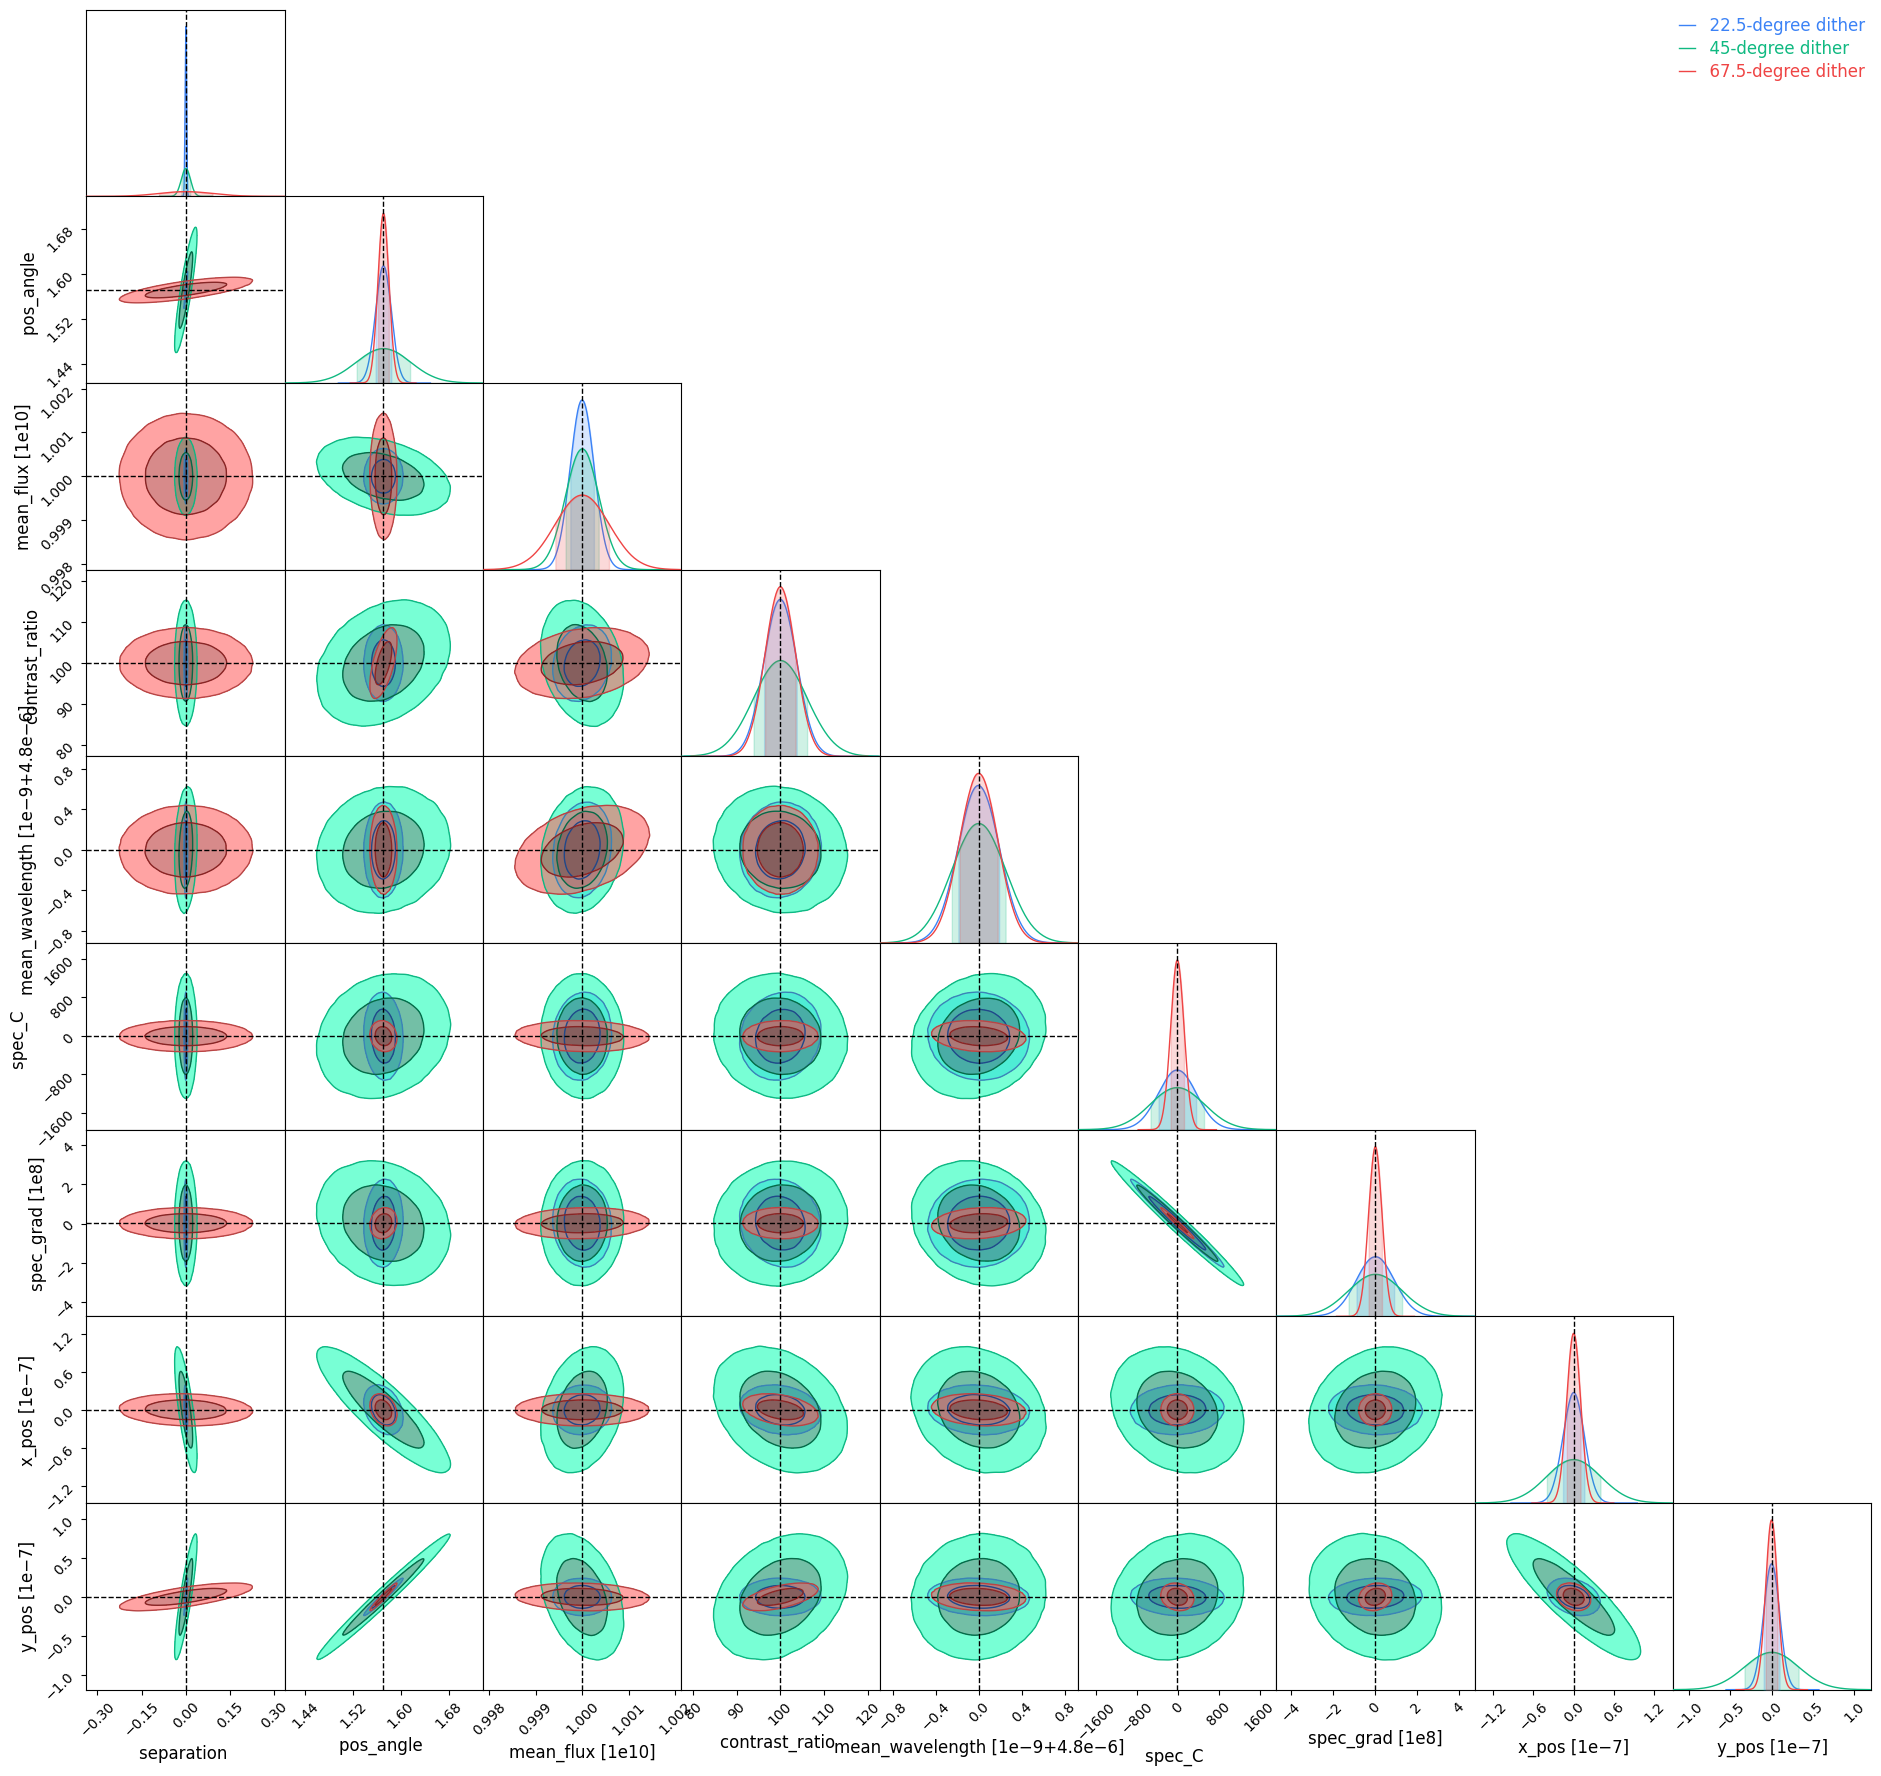

In [283]:
# let us plot some results:
X = np.array([separation, np.pi/2, flux, contrast, 4.8e-6, -8.54, 2083333, 0, 0])

c = ChainConsumer()

# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_array[1][0], columns=param_names, name="x-aligned dither")
# )

c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_array[3][1], columns=param_names, name="22.5-degree dither")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_array[3][2], columns=param_names, name="45-degree dither")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_array[3][3], columns=param_names, name="67.5-degree dither")
)

# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_array[1][4], columns=param_names, name="y-aligned")
# )

c.add_truth(Truth(location={"separation": separation, "pos_angle": np.pi/2, "mean_flux": flux, "contrast_ratio": contrast, "mean_wavelength": 4.8e-6, 
            "x_pos": 0, "y_pos": 0, "spec_C" : -8.54, "spec_grad": 2083333}))

fig = c.plotter.plot()
# Curious

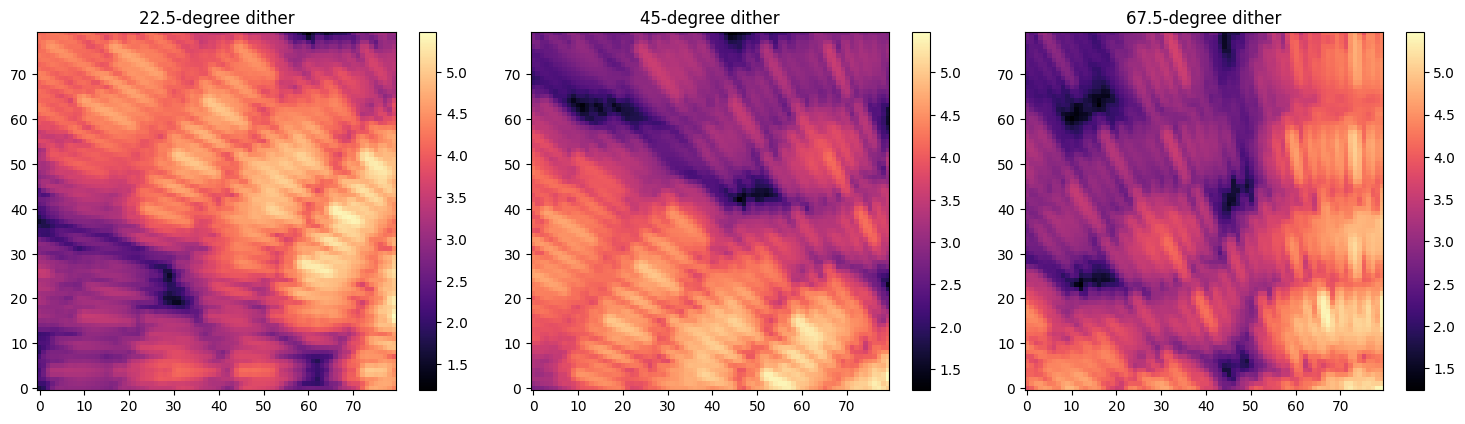

maximum photoelectron count:
299999.9923317747


In [290]:
# alright this is looking good!
idx = 2
dithers = dlu.arcsec2rad(np.array([[radials_array[idx][1]*np.cos(angles[1]),-radials_array[idx][1]*np.sin(angles[1])],
                            [radials_array[idx][2]*np.cos(angles[2]),-radials_array[idx][2]*np.sin(angles[2])],
                            [radials_array[idx][3]*np.cos(angles[3]),-radials_array[idx][3]*np.sin(angles[3])]]))

model = dl.Dither(dithers, optics, source, detector)

data = model.model()

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title('22.5-degree dither')
plt.imshow(np.log10(data[0]), origin='lower', cmap='magma')
plt.colorbar()


plt.subplot(1,3,2)
plt.title('45-degree dither')
plt.imshow(np.log10(data[1]), origin='lower', cmap='magma')
plt.colorbar()

plt.subplot(1,3,3)
plt.title('67.5-degree dither')
plt.imshow(np.log10(data[2]), origin='lower', cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()
print('maximum photoelectron count:')
print(np.max(data))

/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/Users/milolangker/anaconda3/envs/amgioenv/lib/python3.11/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


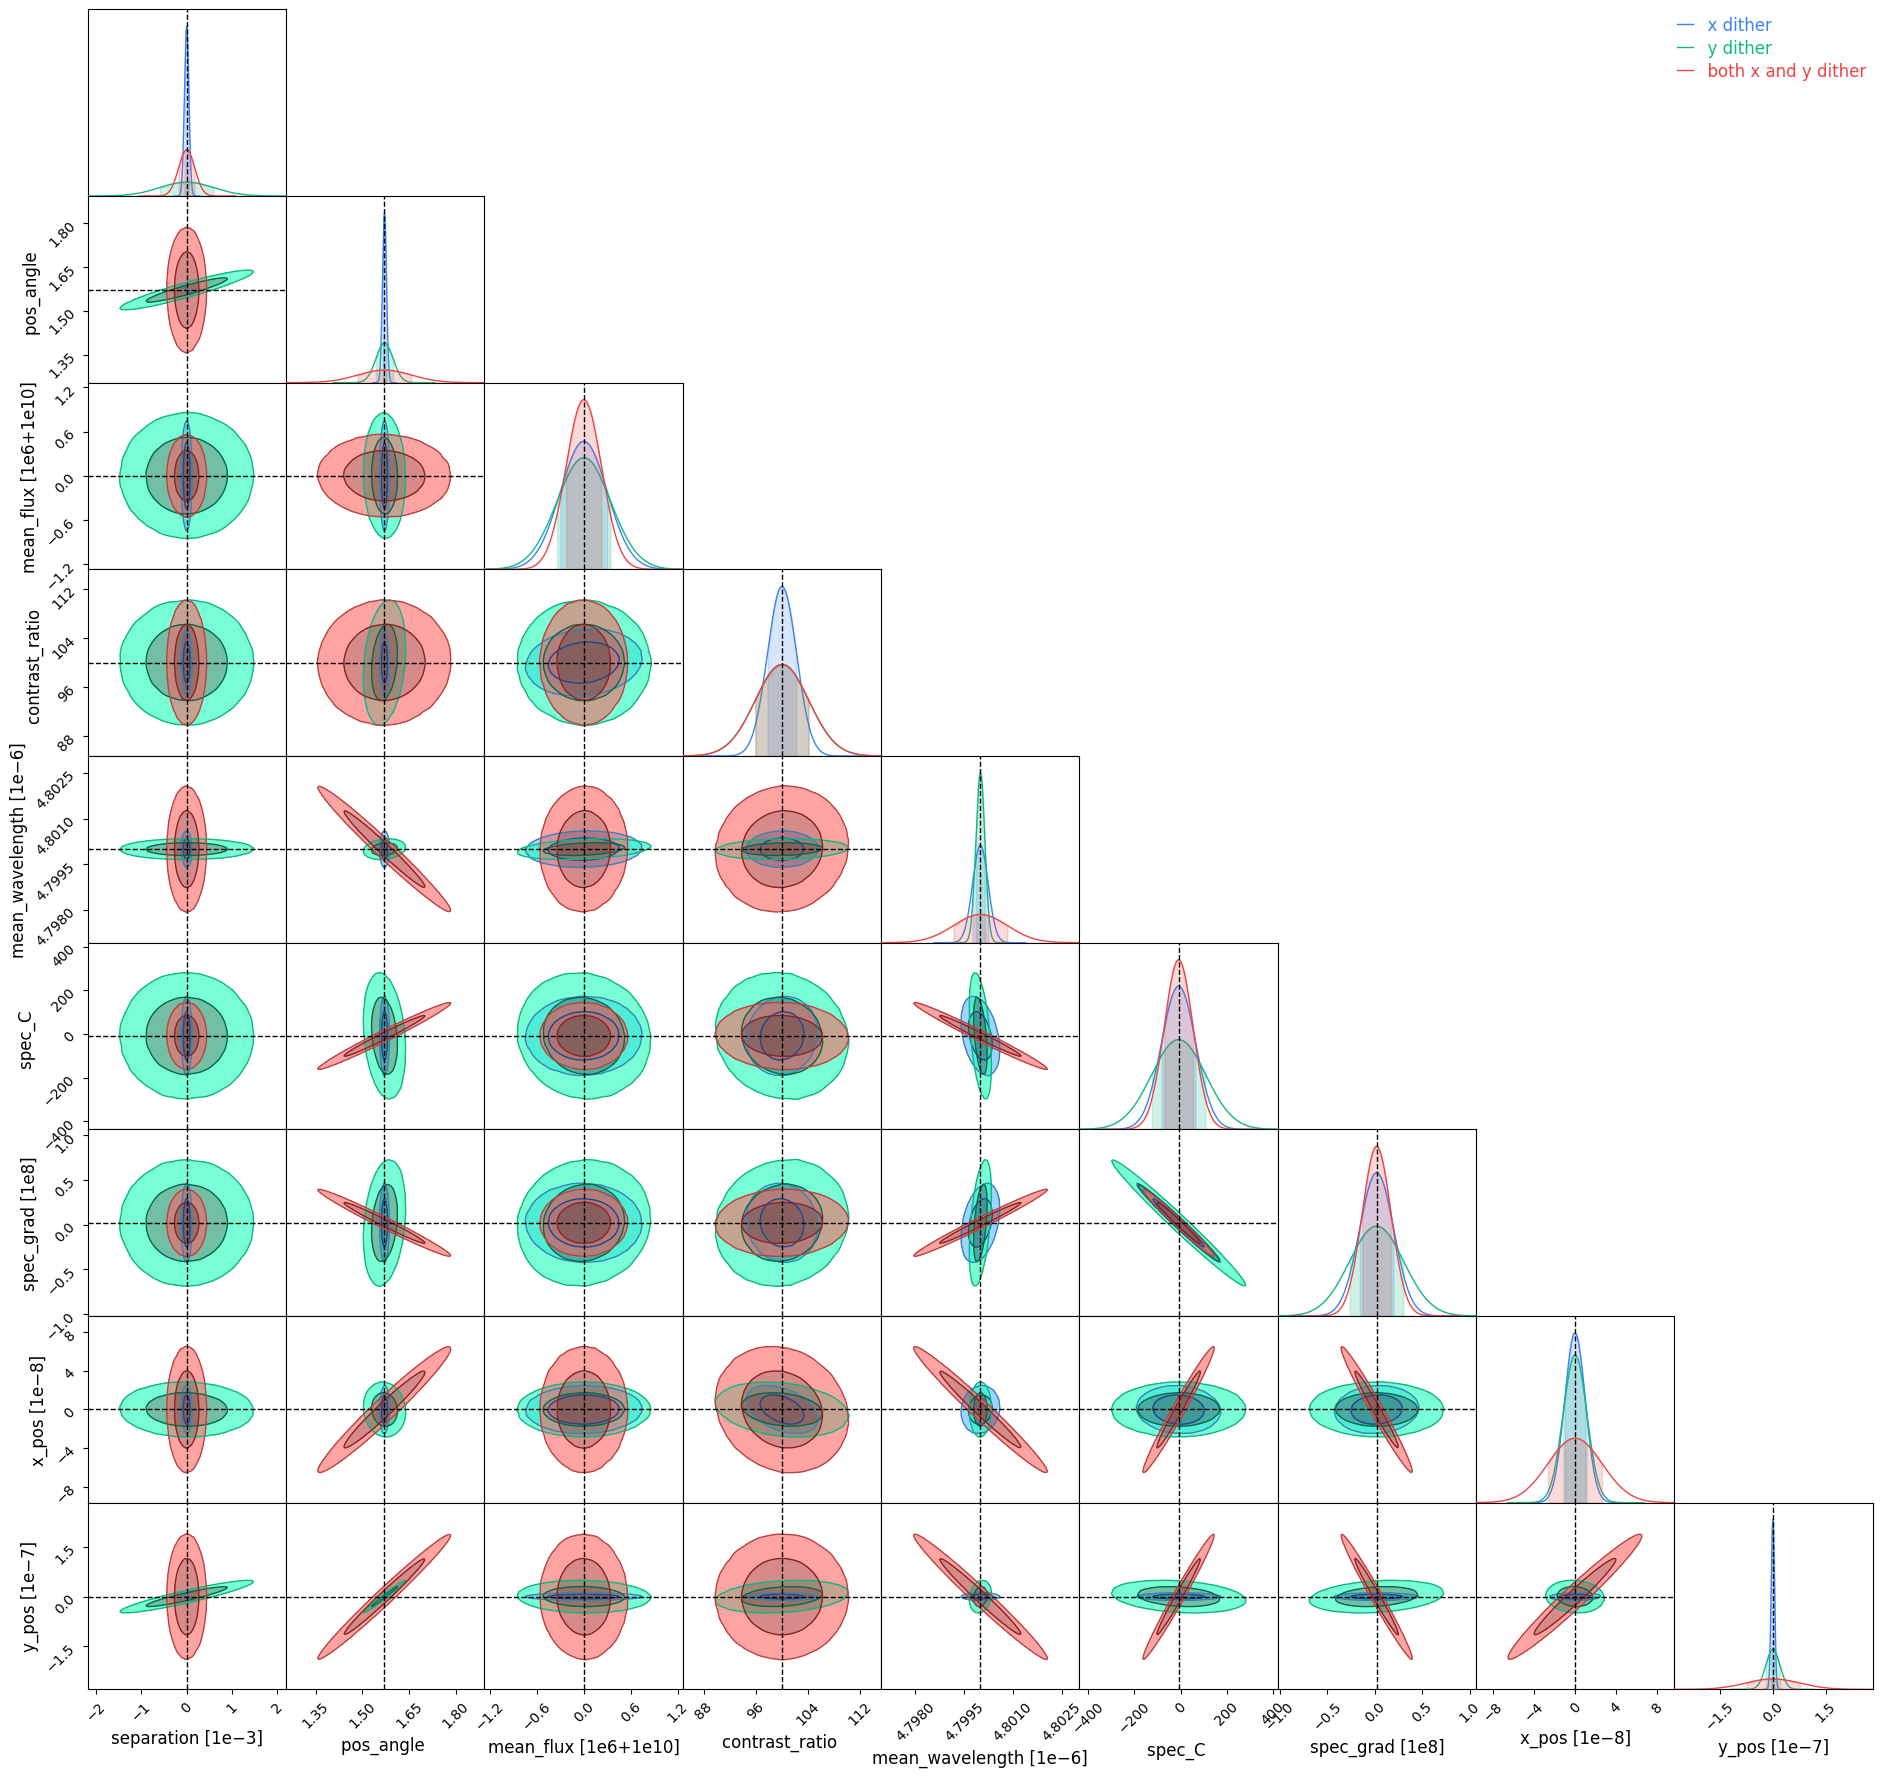

In [296]:
# make two dithers
idx = 2
# dithers = dlu.arcsec2rad(np.array([[radials_array[idx][0]*np.cos(angles[0]),-radials_array[idx][0]*np.sin(angles[0])],
#                             [radials_array[idx][4]*np.cos(angles[4]),-radials_array[idx][4]*np.sin(angles[4])]]))


# model = dl.Dither(dithers, optics, source, detector)

# data = model.model()

# cov_2dithers = zdx.covariance_matrix(model, marginal_params, poiss_loglike, data=data, shape_dict=shape_dict)

# 
X = np.array([separation, np.pi/2, flux, contrast, 4.8e-6, -8.54, 2083333, 0, 0])

c = ChainConsumer()

# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_array[1][0], columns=param_names, name="x-aligned dither")
# )
cov_total = np.linalg.pinv( np.linalg.pinv(covs_array[idx][0]) + np.linalg.pinv(covs_array[idx][4]) )
c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_array[idx][0], columns=param_names, name="x dither")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=covs_array[idx][4], columns=param_names, name="y dither")
)

c.add_chain(
    Chain.from_covariance(mean=X, covariance=cov_total, columns=param_names, name="both x and y dither")
)

# c.add_chain(
#     Chain.from_covariance(mean=X, covariance=covs_array[1][4], columns=param_names, name="y-aligned")
# )

c.add_truth(Truth(location={"separation": separation, "pos_angle": np.pi/2, "mean_flux": flux, "contrast_ratio": contrast, "mean_wavelength": 4.8e-6, 
            "x_pos": 0, "y_pos": 0, "spec_C" : -8.54, "spec_grad": 2083333}))

fig = c.plotter.plot()
# Curious

In [294]:
# might call it there...
# plots to make
dlu.rad2arcsec(1e-5)

2.0626480624709638

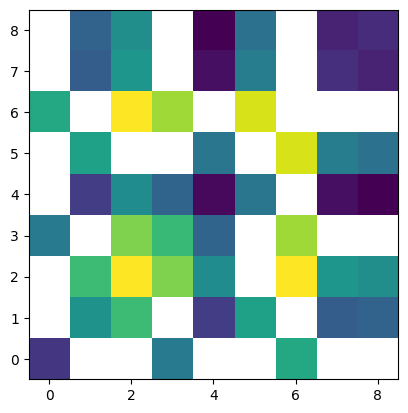

In [299]:
plt.imshow(np.log10(covs_array[idx][0]))

In [300]:
np.save("ami_transmission",transmission)